# UNIVERSIDAD NACIONAL DE CÓRDOBA#
## Fa.M.A.F – Observatorio Astronómico ##
### Licenciatura en Astronomía ###
### Tapia Martina ###
### Astrometría 2020 ###
## Práctico N° 4: Inferencia Bayesiana con métodos Monte Carlo: Cadenas de Markov##

## Introducción ##

En este notebook se llevará a cabo la última parte del estudio de interferencia Bayesiana con métodos Monte Carlo.  
El *objetivo* es minimizar funciones, mediante la técnica del gradiente descendente.  

## Conceptos Básicos ##

### Cuadrados mínimos no-lineales ###
Si se considera ahora un ajuste de un modelo que depende no-linealmente sobre un conjunto de M parámetros $a_{k}$; k = 1, . . . , M. El procedimiento es básicamente el mismo que con los otros métodos trabajados, ya que la función de mérito es la $\chi^2$ y se intenta la busqueda de los parámetros que minimizan esa función. Sin embargo, el proceso de búsqueda en este caso debe ser
iterativo. La idea es dar valores iniciales y desarrollar un procedimiento para mejorarlos. El procedimiento se repite hasta que $\chi^2$ deje de crecer. Entonces, se tiene una función o modelo del tipo:  

$$ y(x) = \sum_{i=1}^{M}f_{i}(\vec{a_i}x) = y(x| \vec{a}) $$  

y por lo tanto  

$$ \chi^2(\vec{a}) = \sum_{i=1}^N [\frac{y_{i} − y(x_{i}|\vec{a})}{\sigma_i^2}] $$

Un procedimiento a aplicar para mejorar un conjunto inicial de parámetros es seguir la dirección de máximo crecimiento (o decrecimiento) indicada por el gradiente de una función. En este caso, el gradiente que se busca es el de la función $\chi^2$.  
### Método del gradiente descendiente ###  

El método que usa el gradiente como indicador para optimizar los parámetros es el denominado “Gradiente Descendiente”, en el cual:  

$$ \vec{a_{new}} = \vec{a_{old}} + \eta * \nabla \chi^2(\vec{a_{old}})$$ 

donde el parámetro $\nu $ es el tamaño del paso que se puede adoptar como fijo.  

Ahora, como se elege el parámetro $\eta$?. En el caso en el que se esta cerca del punto crítico (mínimo o máximo) el gradiente $\nabla \chi^2 $ varía muy poco, porque la superficie es bastante plana, por lo tanto multiplicar por un $\eta$ muy chico hace que se avance muy poco, lo cual hace que sean necesarios muchos pasos. En el caso de que el valor de $\eta$ sea muy grande, los parámetros nuevos oscilan mucho (péndulo) en la zona del mínimo, haciendo difícil la convergencia.  
Existe un método de selección del $\eta$ que se llama “line-search” en el cual se comienza eligiendo un valor pequeño, se hace unos pasos y se mira el comportamiento; si los parámetros no cambian mucho, se cambia el $\eta$ por un valor más grande, se corren un par de pasos y si ve que cambian mucho, se reduce nuevamente el $\eta$.  
En resumen:  
- El método nos permite apuntar en la dirección correcta cuando se esta lejos del mínimo.
- Es muy sensible al valor de $\eta$ adoptado. Si es muy chico, no converge o tarda muchísimo. Si es muy grande, se pasa del mínimo varias veces.


## Implementación del método "Gradiente descendente" ##  

En ésta instancia se implementará el método de gradiente descendente para encontrar el conjunto de parámetros que minimizan la función de $\chi^2$.

In [1]:
#Primero se importan las librerías necesarias para trabajar
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns        
from scipy import stats as st
import functools
sns.set()

In [2]:
# Se importan los datos y sus errores, para ser usados en el notebook
datos = np.genfromtxt('datos2.dat',delimiter=',')
einf = np.genfromtxt('errores_inferiores.dat', delimiter = ',')
esup = np.genfromtxt('errores_superiores.dat', delimiter = ',')

In [3]:
x = datos[:,0]
y = datos[:,1]

In [4]:
ei = einf[:,1]
es = esup[:,1]

In [5]:
e1 = y- ei
e2 = es - y

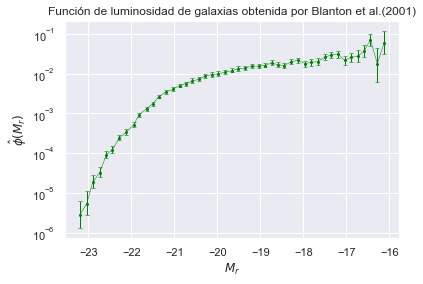

In [6]:
#Se grafica la función luminosidad de galaxias con las barras de error correspondientes

plt.title('Función de luminosidad de galaxias obtenida por Blanton et al.(2001)')
plt.xlabel('$M_{r}$')
plt.ylabel('$\hat \phi(M_{r})$')
plt.yscale('log')
plt.errorbar(x,y, yerr =(e1,e2),marker ='o', markersize=2, color='green',ecolor ='green',elinewidth=1,linewidth=0.5)
plt.plot(x,ei, '_g', markersize=4, )
plt.plot(x, es, '_g', markersize=4)
plt.show()

In [7]:
#Se define la función que representará el modelo de Schechter

def model_Sche(phi0, M0, a, M):
    
    phi1 = []
    for i in range(len(M)):
        
        b = -0.4*(M[i]-M0)*(a+1)
        c = -0.4*(M[i]-M0)
        phi = 0.4 * math.log(10) * phi0 * 10**b * math.exp(-10**c)
        phi1.append(phi)
    
    return(phi1)

In [8]:
#Se verifica si el modelo funciona
M1= np.linspace(-16,-23,100)
y1a = model_Sche(phi0=1.46E-2,M0=-20.83,a=-1.20,M=M1)

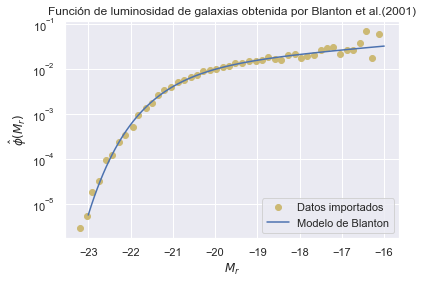

In [9]:
#Se grafica el modelo sobre los puntos para verificar la función modelo

plt.title('Función de luminosidad de galaxias obtenida por Blanton et al.(2001)')
plt.xlabel('$M_{r}$')
plt.ylabel('$\hat \phi(M_{r})$')
plt.yscale('log')
plt.yscale('log')
plt.plot(x,y, 'oy', label='Datos importados')
plt.plot(M1,y1a, label='Modelo de Blanton')
plt.legend(loc='lower right')
plt.show()

In [11]:
#Se define el valor de sigma para trabajar

s = es - ei

Como se explicó anteriormente, lo que se intenta hacer es realizar la búsqueda de los parámetros que minimizan la función $\chi^2$. Por éste motivo, lo primero que se realiza es definir la función $\chi^2$ usando la fórmula descripta en la intrucción. 

In [12]:
def Chi2(datax, datay, phi0, M0, a, s):
   
    chi = 0
    model = model_Sche(phi0, M0, a, datax)
    N = len(datax)
    for i in range(N):    
        
        chi = chi + [(datay[i] - model[i])**2]/ s[i]**2
        
    return(chi)

In [13]:
#Se prueba que la función no tenga errores

Chi2(x, y, phi0=1.46E-2,M0=-20.83,a=-1.20,s=s)

array([6.35851257])

In [174]:
#Se analiza el comportamiento de Chi2 con ayuda de plots

N = 100

PHI = np.linspace(0.0005, 0.025,N)
M_0 = np.linspace(-21.2, -20.2, N)
A_0 = np.linspace(-1.5,-0.9, N)

#Se crean las matrices con ceros 

p_0 = np.zeros((N,N))
m_0 = np.zeros((N,N))
a_0 = np.zeros((N,N))

for ip, p in enumerate(PHI):
    for im, m in enumerate(M_0):
        p_0[im,ip] = Chi2(x, y, p, m, a=-1.20, s = s)

for ip, p in enumerate(PHI):
    for ia, a in enumerate(A_0):
        m_0[ip,ia] = Chi2(x, y, p, M0=-20.83, a=a, s =s )
        
for im, m in enumerate(M_0):
    for ia, a in enumerate(A_0):
        a_0[im,ia] = Chi2(x,y, phi0=1.46E-2, M0 = m, a =a, s = s)



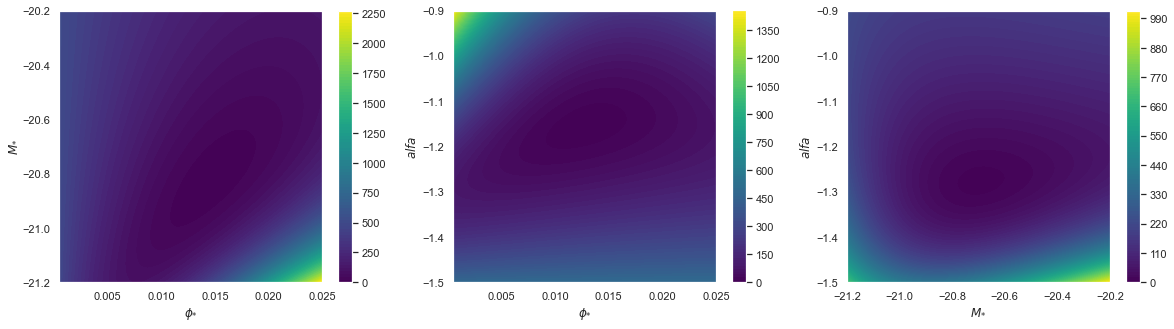

In [15]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.contourf(PHI, M_0, p_0, 100, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel('$\phi_{*}$')
plt.ylabel('$M_{*}$')

plt.subplot(1,3,2)
plt.contourf(PHI, A_0, m_0, 100,cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel('$\phi_{*}$')
plt.ylabel('$alfa$')

plt.subplot(1,3,3)
plt.contourf(M_0, A_0, a_0, 100, cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel('$M_{*}$')
plt.ylabel('$alfa$')

plt.show()

Notar que en éstos gráficos se puede apreciar las zonas donde se encuentra el mínimo en color morado oscuro. Los colores ayudan a visualizar la tercer dimensión, ya que se tienen 3 parámetros a analizar. Luego, usando éstos resultados se pueden definir los puntos iniciales de las cadenas que encotrarán los prámetros que minimizan a $\chi^2$.  

Antes de hacer las cadenas, se debe calcular $\nabla \chi^2$. Para ello, se realizan diferentes funciones que calculen las derivadas involucradas. Realizando éste proceso paso a paso, resultará más sencillo encontrar el error en caso de que luego hayan problemas. 

In [16]:
#Se define la derivada del modelo respecto del parámetro phi0

def dmodel_phi0(phi0, M0, a, M):
    
    dmphi1 = []
    for i in range(len(M)):
        
        b = -0.4*(M[i]-M0)*(a+1)
        c = -0.4*(M[i]-M0)
        dmphi = 0.4 * math.log(10) * 10**b * math.exp(-10**c)
        dmphi1.append(dmphi)
    
    return(dmphi1)    

In [17]:
#Se define la derivada del modelo respecto del parámetro m0

def dmodel_M0(phi0, M0, a, M):
    
    dmM01 = []
    for i in range(len(M)):
        
        A = 0.4*math.log(10)*phi0
        f = 10**(-0.4*(M[i]-M0)*(a+1))
        g = math.exp(-10**(-0.4*(M[i]-M0)))
        df = 10**(-0.4 * (M[i]-M0) * (a + 1))* 0.4 * math.log(10)*(a+1)
        dg = -math.exp(-10**(-0.4*(M[i]-M0))) * 0.4 * math.log(10) * 10**(-0.4 * (M[i]-M0)) 
        dmM0 = A * (df*g + f*dg)
        dmM01.append(dmM0)
        
    return(dmM01)


In [18]:
#Se define la derivada del modelo respecto del parámetro alpha

def dmodel_a(phi0, M0, a, M):
    
    dma1 = []
    for i in range(len(M)):
        
        A = 0.4* math.log(10)*phi0
        f = 10**(-0.4*(M[i]-M0)*(a+1))
        df = 10**(-0.4*(M[i]-M0)*(a+1))*-0.4*math.log(10)*(M[i]-M0)
        g = math.exp(-10**(-0.4*(M[i]-M0)))
        dma = A * df * g  
        dma1.append(dma)
    return(dma1)

In [19]:
#Se calcula el gradiente de Chi cuadrado 
#Se usan las funciones definidas anteriormente

def Gradiente_Chi2(datax, datay, phi0, M0, a, sigma = s):
    
    dchi2_phi0 = 0
    dchi2_m0 = 0
    dchi2_a = 0
    model_pars = model_Sche(phi0, M0, a, datax) 
    dfmodel_phi0 = dmodel_phi0(phi0, M0, a, M = datax)
    dfmodel_m0 = dmodel_M0(phi0, M0, a, M = datax)
    dfmodel_a0 = dmodel_a(phi0, M0, a, M=datax)
    
    for j in range(len(datax)):
        
        dchi2_phi0 = dchi2_phi0 - 2 * (datay[j] - model_pars[j]) / (sigma[j] ** 2) * dfmodel_phi0[j]
        dchi2_m0 = dchi2_m0 - 2 * (datay[j] - model_pars[j]) / (sigma[j] ** 2) * dfmodel_m0[j]
        dchi2_a = dchi2_a - 2 * (datay[j] - model_pars[j]) / (sigma[j] ** 2) * dfmodel_a0[j]

    return np.array([dchi2_phi0, dchi2_m0, dchi2_a])

In [20]:
#Se realiza una prueba de la funcion 

Gradiente_Chi2(x, y, 0.0146, -20.83, -1.20, s)

array([43.66110517, -1.21269182, -4.30340269])

Una vez obtenidas las derivadas y calculado el gradiente de $\chi^2$, se procede a la aplicación del método Gradiente descendente realizando una función que devuelve tres listas, una para cada parámetro, siendo el último el valor que minimiza la función $\chi^2$.

In [21]:
def Gradiente_descendente(x, y, n, N_pasos):
    
    #Se inicializan los parámetros
    grad = np.array([0,0,0])
    while np.any(grad < (1.E-8)):
        
        phi0_inicial = random.uniform(0.0004, 0.025)
        m0_inicial = random.uniform(-21.0, -20.5)
        a0_inicial = random.uniform(-1.5, -0.9)
    
        grad = Gradiente_Chi2(x, y, phi0_inicial, m0_inicial, a0_inicial, s)
    
    #Se crean las listas para guardar los resultados
    camino_phi0 = [phi0_inicial]
    camino_m0 = [m0_inicial]
    camino_a = [a0_inicial]
    
    for i in range(1, N_pasos):
        phi0_inicial = phi0_inicial - n * (grad[0]) * (10**-6)
        m0_inicial = m0_inicial - n * (grad[1]) * (10**-2)
        a0_inicial = a0_inicial - n * (grad[2]) * (10**-3)
        
        grad = Gradiente_Chi2(x, y, phi0_inicial, m0_inicial, a0_inicial, s)
        
        camino_phi0.append(phi0_inicial)
        camino_m0.append(m0_inicial)
        camino_a.append(a0_inicial)
        
    return(camino_phi0, camino_m0, camino_a)
    
    

In [29]:
#Se ejecuta la función 
g1 = Gradiente_descendente(x, y, n = 0.05, N_pasos = 10)

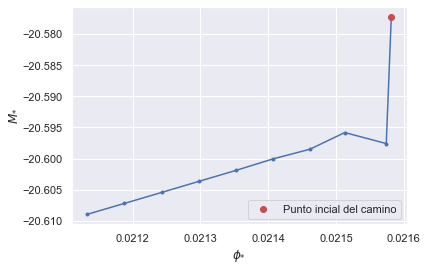

In [37]:
#Se grafica el resultado para obtener una mejor visualización 
#Se grafican dos parámetros a modo representativo

plt.plot(g1[0], g1[1], marker='.')
plt.plot(g1[0][0], g1[1][0], 'or', label = 'Punto incial del camino')
plt.xlabel('$\phi_{*}$')
plt.ylabel('$M_{*}$')
plt.legend(loc='lower right')

Notar que, usando un $\eta$ = 0.05 y haciendo 10 pasos, los parámetros obtenidos no están cerca de los valores conocidos por Blanton. Se agrande $\eta$ a 0.06 con la misma cantidad de pasos y se obtiene 

In [47]:
g2 = Gradiente_descendente(x, y, n = 0.06, N_pasos = 10)

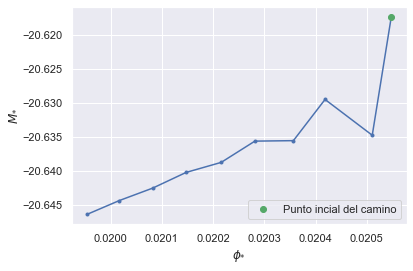

In [48]:
plt.plot(g2[0], g2[1], marker='.')
plt.plot(g2[0][0], g2[1][0], 'og', label = 'Punto incial del camino')
plt.xlabel('$\phi_{*}$')
plt.ylabel('$M_{*}$')
plt.legend(loc='lower right')

Variando levemente el valor de $\eta$ no se aprecian grandes cambios en los parámetros obtenidos.  
Luego, lo que se hace es variar la cantidad de pasos dejando fijo el valor de $\eta$.

In [49]:
g3 = Gradiente_descendente(x, y, n = 0.06, N_pasos = 100)

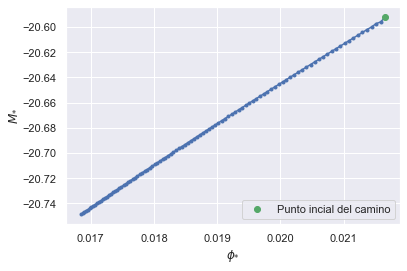

In [50]:
plt.plot(g3[0], g3[1], marker='.')
plt.plot(g3[0][0], g3[1][0], 'og', label = 'Punto incial del camino')
plt.xlabel('$\phi_{*}$')
plt.ylabel('$M_{*}$')
plt.legend(loc='lower right')

Se puede ver aquí, que los valores para phi0 y m0 se acercan mucho más a los de Blanton. Es decir que se debe comprueba lo enunciado en el apartado de conceptos básicos. En el caso en el que se esta cerca del punto crítico (mínimo) el gradiente $\nabla \chi^2 $ varía muy poco, porque la superficie es bastante plana, por lo tanto multiplicar por un $\eta$ muy chico hace que se avance muy poco, lo cual hace que sean necesarios muchos pasos. Por otra parte, si el valor de $\eta$ es muy grande, los parámetros nuevos oscilan mucho (péndulo) en la zona del mínimo, haciendo difícil la convergencia. Entonces, lo que se necesita es lograr un equilibrio entre la cantidad de pasos y el valor de $\eta$.

In [110]:
#En este paso, se mostrará lo que ocurre si eta es muy grande 
#En el gráfico se puede visualizar la oscilación predicha

g4 = Gradiente_descendente(x, y, n = 0.09, N_pasos = 50)

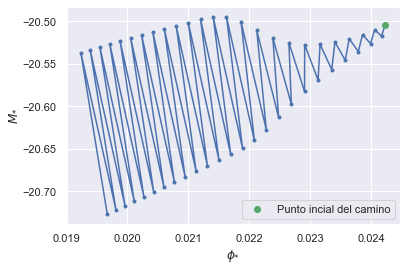

In [111]:
plt.plot(g4[0], g4[1], marker='.')
plt.plot(g4[0][0], g4[1][0], 'og', label = 'Punto incial del camino')
plt.xlabel('$\phi_{*}$')
plt.ylabel('$M_{*}$')
plt.legend(loc='lower right')

In [157]:
#Se intentará lograr un equilibro entre eta y el numero de pasos 
g5 = Gradiente_descendente(x, y, n = 0.07, N_pasos = 170)

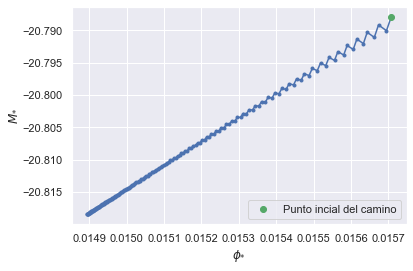

In [159]:
plt.plot(g5[0], g5[1], marker='.')
plt.plot(g5[0][0], g5[1][0], 'og', label = 'Punto incial del camino')
plt.xlabel('$\phi_{*}$')
plt.ylabel('$M_{*}$')
plt.legend(loc='lower right')

Con la última elección, $\eta$ = 0.07 y realizando 170 pasos se logró obtener mejores valores para los parámetros.  
A continuación se graficará el modelo, valuado en los parámetros de Blanton, y el modelo con los parámetros encontrados con la función Gradiente descendente. 

In [169]:
ypars = model_Sche(phi0=g5[0][169],M0=g5[1][169],a=g5[2][169],M=x)
yblanton = model_Sche(phi0=1.46E-2,M0=-20.83,a=-1.20,M=x)

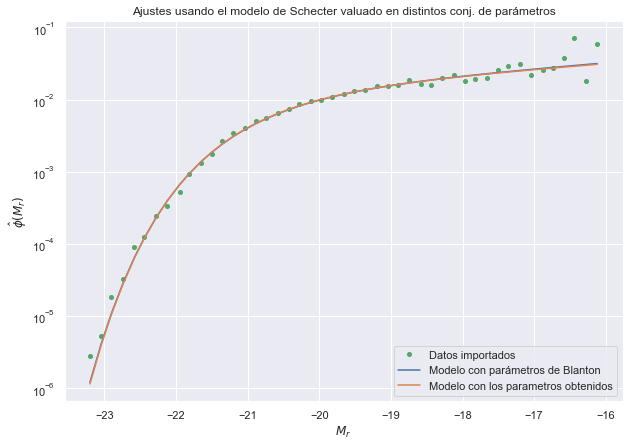

In [175]:
plt.figure(figsize=(10,7))
plt.title('Ajustes usando el modelo de Schecter valuado en distintos conj. de parámetros')
plt.xlabel('$M_{r}$')
plt.ylabel('$\hat \phi(M_{r})$')
plt.yscale('log')
plt.yscale('log')
plt.plot(x,y, 'og', label='Datos importados', markersize=4)
plt.plot(x,yblanton, label='Modelo con parámetros de Blanton')
plt.plot(x,ypars, label='Modelo con los parametros obtenidos')
plt.legend(loc='lower right')
plt.show()

Al graficar los modelos con los diferentes conjuntos de parámetros, se puede ver que los ajustes a los datos son muy similares. No se registran grandes difencias en los modelos, e incluso en la mayor parte de los datos los modelos coinciden. 

## Conclusión ##  

El *objetivo* de minimizar la función $\chi^2$ se logró satisfactoriamente. La técnica del gradiente descendente fue aplicada de forma correcta, ya que los parámetros encontrados a partir de ella, estan estrechamente relacionados con los obtenidos por Blanton et. al.(2001).  
Respecto a los valores del parámetro $\eta$ se pudo ver que es complicado determinarlo con presición, ya que en el caso de no tener valores de referencia para los parámetros (en este caso los encontrados por Blanton et. al.) sería mucho más difícil de saber cuando los valores de los parámetros estan cercanos a los 'correctos'. De la misma manera, el número de pasos necesarios para lograr la convergencia de la cadena es dificil de determinar si no se tiene una referencia.  
Finalmente, a pesar de las dificultades para encontrar el $\eta$ y el número de pasos correcto, se pudo lograr encontrar los  parámetros tales que la función $\chi^2$ sea mínima.  

Los valores encontrados son: 

$$\phi_{*} = 1.49E-2,  M_{*} = -20.82, \alpha = -1.19 $$  

Finalmente, notar que éstos valores son muy similares a los econtrados en las actividades anterior donde se usaron las cadenas de Markov y el método de Metrópolis-Hastings.
